# 🌍 Air Quality — Visualizations
This notebook generates static and interactive visualizations from the pipeline outputs 

In [ ]:
! pip install plotly folium ipywidgets python-pptx

import os
from pathlib import Path
import json
import warnings
warnings.filterwarnings("ignore")

# Create output folders
FIG_DIR = Path("analysis_outputs/figures")
MAP_DIR = Path("analysis_outputs/maps")
FIG_DIR.mkdir(parents=True, exist_ok=True)
MAP_DIR.mkdir(parents=True, exist_ok=True)

print("Figures to:", FIG_DIR.resolve())
print("Maps to:", MAP_DIR.resolve())


Figures to: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\figures
Maps to: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\maps


In [1]:
# Robust file-read helpers for the notebook
from pathlib import Path
import pandas as pd
import traceback

def try_read_parquet(path):
    """
    Return a DataFrame if parquet exists and is readable, otherwise None.
    """
    p = Path(path)
    try:
        if p.exists():
            df = pd.read_parquet(p)
            return df
        return None
    except Exception as e:
        print(f"⚠️ Failed to read parquet {p}:", e)
        traceback.print_exc(limit=1)
        return None

def try_read_csv(path, parse_dates=None, nrows_preview=0):
    """
    Read CSV if present. If parse_dates is given, inspect file columns first
    and only pass the parse_dates columns that actually exist (avoids ValueError).
    Returns DataFrame or None on missing file / failure.
      - path: Path or str
      - parse_dates: None or list/tuple/str of column(s) to parse as dates
    """
    p = Path(path)
    try:
        if not p.exists():
            return None

        # If parse_dates is provided, check which of those columns exist in the file
        cols_to_parse = None
        if parse_dates:
            # read only header to inspect column names (fast)
            preview = pd.read_csv(p, nrows=nrows_preview)  # nrows=0 returns only columns
            available_cols = set(preview.columns.tolist())
            if isinstance(parse_dates, (list, tuple)):
                cols_to_parse = [c for c in parse_dates if c in available_cols]
            else:
                cols_to_parse = [parse_dates] if parse_dates in available_cols else []
        # actually read with guarded parse_dates
        if cols_to_parse:
            return pd.read_csv(p, parse_dates=cols_to_parse)
        else:
            # read without parse_dates to avoid ValueError
            return pd.read_csv(p)
    except Exception as e:
        print(f"⚠️ Failed to read CSV {p}: {e}")
        traceback.print_exc(limit=1)
        return None


def save_fig(fig, filename, dpi=150):
    out = FIG_DIR / filename
    fig.savefig(out, bbox_inches="tight", dpi=dpi)
    print("Saved:", out)


In [2]:
# auto-detect project root (works if notebook runs from project root or analysis/ subfolder)
from pathlib import Path

cwd = Path.cwd()
if (cwd / "data_lake").exists():
    project_root = cwd
elif (cwd.parent / "data_lake").exists():
    project_root = cwd.parent
else:
    # fallback: allow user to set manually (set PROJECT_ROOT variable), else raise
    try:
        project_root  # if previously set by user
    except NameError:
        raise FileNotFoundError(
            "Cannot detect project root (no data_lake/ folder found). "
            "Either run notebook from project root or set project_root manually."
        )

print("Detected project root:", project_root)

# paths relative to project root
features_path = project_root / "data_lake/feature_sets/features.parquet"
trend_summary_path = project_root / "analysis_outputs/trends/trend_summary.csv"
forecast_summary_path = project_root / "analysis_outputs/forecasts/forecast_summary.csv"

# Use the robust helpers
df_features = try_read_parquet(features_path)
trend_summary = try_read_csv(trend_summary_path, parse_dates=['date'])
forecast_summary = try_read_csv(forecast_summary_path, parse_dates=['date'])

print("features:", "found" if df_features is not None else "missing")
print("trend_summary:", "found" if trend_summary is not None else "missing")
print("forecast_summary:", "found" if forecast_summary is not None else "missing")

if df_features is not None:
    print("✅ features shape:", df_features.shape)
    print("Columns:", df_features.columns.tolist())

# If a CSV was read without parse_dates but you want to parse later:
if trend_summary is not None and 'date' in trend_summary.columns and not pd.api.types.is_datetime64_any_dtype(trend_summary['date']):
    trend_summary['date'] = pd.to_datetime(trend_summary['date'], errors='coerce')


Detected project root: c:\Users\HP\Desktop\Capstone Project
features: found
trend_summary: found
forecast_summary: found
✅ features shape: (120, 7)
Columns: ['Date', 'O3_ug_m3', 'location_inferred', 'year', 'month', 'year_month', 'O3_ug_m3_rolling_60m']


In [3]:
# Robust file-read helpers for the notebook
from pathlib import Path
import pandas as pd
import traceback

def try_read_parquet(path):
    """
    Return a DataFrame if parquet exists and is readable, otherwise None.
    """
    p = Path(path)
    try:
        if p.exists():
            df = pd.read_parquet(p)
            return df
        return None
    except Exception as e:
        print(f"⚠️ Failed to read parquet {p}:", e)
        traceback.print_exc(limit=1)
        return None

def try_read_csv(path, parse_dates=None, nrows_preview=0):
    """
    Read CSV if present. If parse_dates is given, inspect file columns first
    and only pass the parse_dates columns that actually exist (avoids ValueError).
    Returns DataFrame or None on missing file / failure.
      - path: Path or str
      - parse_dates: None or list/tuple/str of column(s) to parse as dates
    """
    p = Path(path)
    try:
        if not p.exists():
            return None

        # If parse_dates is provided, check which of those columns exist in the file
        cols_to_parse = None
        if parse_dates:
            # read only header to inspect column names (fast)
            preview = pd.read_csv(p, nrows=nrows_preview)  # nrows=0 returns only columns
            available_cols = set(preview.columns.tolist())
            if isinstance(parse_dates, (list, tuple)):
                cols_to_parse = [c for c in parse_dates if c in available_cols]
            else:
                cols_to_parse = [parse_dates] if parse_dates in available_cols else []
        # actually read with guarded parse_dates
        if cols_to_parse:
            return pd.read_csv(p, parse_dates=cols_to_parse)
        else:
            # read without parse_dates to avoid ValueError
            return pd.read_csv(p)
    except Exception as e:
        print(f"⚠️ Failed to read CSV {p}: {e}")
        traceback.print_exc(limit=1)
        return None


In [6]:
# auto-detect project root (works if notebook runs from project root or analysis/ subfolder)
from pathlib import Path

cwd = Path.cwd()
if (cwd / "data_lake").exists():
    project_root = cwd
elif (cwd.parent / "data_lake").exists():
    project_root = cwd.parent
else:
    # fallback: allow user to set manually (set PROJECT_ROOT variable), else raise
    try:
        project_root  # if previously set by user
    except NameError:
        raise FileNotFoundError(
            "Cannot detect project root (no data_lake/ folder found). "
            "Either run notebook from project root or set project_root manually."
        )

print("Detected project root:", project_root)

# paths relative to project root
features_path = project_root / "data_lake/feature_sets/features.parquet"
trend_summary_path = project_root / "analysis_outputs/trends/trend_summary.csv"
forecast_summary_path = project_root / "analysis_outputs/forecasts/forecast_summary.csv"

# Use the robust helpers
df_features = try_read_parquet(features_path)
trend_summary = try_read_csv(trend_summary_path, parse_dates=['date'])
forecast_summary = try_read_csv(forecast_summary_path, parse_dates=['date'])

print("features:", "found" if df_features is not None else "missing")
print("trend_summary:", "found" if trend_summary is not None else "missing")
print("forecast_summary:", "found" if forecast_summary is not None else "missing")

if df_features is not None:
    print("✅ features shape:", df_features.shape)
    print("Columns:", df_features.columns.tolist())

# If a CSV was read without parse_dates but you want to parse later:
if trend_summary is not None and 'date' in trend_summary.columns and not pd.api.types.is_datetime64_any_dtype(trend_summary['date']):
    trend_summary['date'] = pd.to_datetime(trend_summary['date'], errors='coerce')


Detected project root: c:\Users\HP\Desktop\Capstone Project
features: found
trend_summary: found
forecast_summary: found
✅ features shape: (120, 7)
Columns: ['Date', 'O3_ug_m3', 'location_inferred', 'year', 'month', 'year_month', 'O3_ug_m3_rolling_60m']


In [8]:
# Basic time conversion
if df_features is not None:
    date_col = next((c for c in df_features.columns if c.lower() == 'date' or c.lower() == 'date_time' or c.lower()=='date'), 'date')
    df_features[date_col] = pd.to_datetime(df_features[date_col])
    display(df_features.head())

    # If value col not auto-known, try to detect a numeric pollutant column
    pollutant_candidates = [c for c in df_features.columns if c not in [date_col, location_col, 'year','month','year_month'] and pd.api.types.is_numeric_dtype(df_features[c])]
    print("Numeric candidates:", pollutant_candidates[:6])
    value_col = pollutant_candidates[0] if pollutant_candidates else None
    print("Using value_col:", value_col)
else:
    value_col = None


In [12]:
from pathlib import Path

# try to find project root by walking up until we find data_lake
cwd = Path.cwd()
root = cwd
for _ in range(10):   # limit how far up we go
    if (root / "data_lake").exists():
        break
    if root.parent == root:
        break
    root = root.parent

print("Assumed project root:", root)

# build expected paths relative to discovered project root
features_path = root / "data_lake" / "feature_sets" / "features.parquet"
trend_summary_path = root / "analysis_outputs" / "trends" / "trend_summary.csv"
forecast_summary_path = root / "analysis_outputs" / "forecasts" / "forecast_summary.csv"

for p in (features_path, trend_summary_path, forecast_summary_path):
    print(p.resolve(), "=> exists?", p.exists())


Assumed project root: c:\Users\HP\Desktop\Capstone Project
C:\Users\HP\Desktop\Capstone Project\data_lake\feature_sets\features.parquet => exists? True
C:\Users\HP\Desktop\Capstone Project\analysis_outputs\trends\trend_summary.csv => exists? True
C:\Users\HP\Desktop\Capstone Project\analysis_outputs\forecasts\forecast_summary.csv => exists? True


In [13]:
from pathlib import Path

# Automatically detect project root
cwd = Path.cwd()
root = cwd

for _ in range(10):
    if (root / "data_lake").exists():
        break
    root = root.parent

# Final resolved paths
features_path = root / "data_lake" / "feature_sets" / "features.parquet"
trend_summary_path = root / "analysis_outputs" / "trends" / "trend_summary.csv"
forecast_summary_path = root / "analysis_outputs" / "forecasts" / "forecast_summary.csv"

print("Features path:", features_path)
print("Trend summary path:", trend_summary_path)
print("Forecast summary path:", forecast_summary_path)


Features path: c:\Users\HP\Desktop\Capstone Project\data_lake\feature_sets\features.parquet
Trend summary path: c:\Users\HP\Desktop\Capstone Project\analysis_outputs\trends\trend_summary.csv
Forecast summary path: c:\Users\HP\Desktop\Capstone Project\analysis_outputs\forecasts\forecast_summary.csv


In [14]:
df_features = try_read_parquet(features_path)
trend_summary = try_read_csv(trend_summary_path, parse_dates=["date"])
forecast_summary = try_read_csv(forecast_summary_path)


In [15]:
print("df_features:", "OK" if df_features is not None else "missing")
print("trend_summary:", "OK" if trend_summary is not None else "missing")
print("forecast_summary:", "OK" if forecast_summary is not None else "missing")

if df_features is not None:
    print(df_features.shape)
    print(df_features.head())


df_features: OK
trend_summary: OK
forecast_summary: OK
(120, 7)
        Date    O3_ug_m3 location_inferred  year  month year_month  \
0 2010-01-01   65.230370               all  2010      1    2010-01   
1 2010-02-01   73.753571               all  2010      2    2010-02   
2 2010-03-01   95.402581               all  2010      3    2010-03   
3 2010-04-01  119.055333               all  2010      4    2010-04   
4 2010-05-01   99.751613               all  2010      5    2010-05   

   O3_ug_m3_rolling_60m  
0             65.230370  
1             69.491971  
2             78.128841  
3             88.360464  
4             90.638694  


In [18]:
# inspect columns / index to find a location-like column
import re

print("Columns:")
cols = list(df_features.columns)
for c in cols:
    print(" ", repr(c))

# also show index names (in case 'location' is in the index)
print("\nIndex names:", getattr(df_features.index, "names", None))
print("\nIndex head:")
print(df_features.index[:5])

# search for likely column names (case-insensitive, also match substrings)
candidates = [c for c in cols if any(k in c.lower() for k in ("location", "loc", "region"))]

print("\nLocation-like candidates:", candidates)

# pick a candidate or raise friendly error
if candidates:
    location_col = candidates[0]
    print(f"Using column '{location_col}' for grouping.")
    print(df_features.groupby(location_col).size().sort_values(ascending=False).head(20))
else:
    # if location could be in the index (e.g. MultiIndex)
    idx_names = df_features.index.names if hasattr(df_features.index, "names") else []
    idx_candidates = [n for n in (idx_names or []) if n and any(k in str(n).lower() for k in ("location","loc","region"))]
    if idx_candidates:
        idx_col = idx_candidates[0]
        print(f"Found location-like level in index: {idx_col}. Using index level for grouping.")
        print(df_features.groupby(level=idx_col).size().sort_values(ascending=False).head(20))
    else:
        raise KeyError(
            "No location-like column found. Columns printed above. "
            "If you expect a column such as 'location', 'loc', 'region' or 'location_inferred', "
            "rename or create it first, for example:\n\n"
            "df_features['location'] = df_features['location_inferred']   # if present\n"
            "or\n"
            "df_features['location'] = df_features['loc']\n\n"
            "Then run: df_features.groupby('location').size()"
        )


Columns:
  'Date'
  'O3_ug_m3'
  'location_inferred'
  'year'
  'month'
  'year_month'
  'O3_ug_m3_rolling_60m'

Index names: [None]

Index head:
RangeIndex(start=0, stop=5, step=1)

Location-like candidates: ['location_inferred']
Using column 'location_inferred' for grouping.
location_inferred
all    120
dtype: int64


In [19]:
preferred = ["location", "location_inferred", "loc", "region"]
for p in preferred:
    if p in df_features.columns:
        df_features = df_features.rename(columns={p: "location"})
        print("Renamed", p, "-> location")
        break
else:
    print("No preferred column found. See columns:", df_features.columns.tolist())

# now group safely (if rename succeeded)
if "location" in df_features.columns:
    print(df_features.groupby("location").size().sort_values(ascending=False).head(30))


Renamed location_inferred -> location
location
all    120
dtype: int64


In [20]:
# columns, types, nulls
print(df_features.columns.tolist())
print(df_features.dtypes)
print(df_features.isna().sum())


['Date', 'O3_ug_m3', 'location', 'year', 'month', 'year_month', 'O3_ug_m3_rolling_60m']
Date                    datetime64[ns]
O3_ug_m3                       float64
location                        object
year                             int32
month                            int32
year_month                      object
O3_ug_m3_rolling_60m           float64
dtype: object
Date                    0
O3_ug_m3                0
location                0
year                    0
month                   0
year_month              0
O3_ug_m3_rolling_60m    0
dtype: int64


In [21]:
top_locations = df_features.groupby("location").size().sort_values(ascending=False)
print(top_locations.head(20))


location
all    120
dtype: int64


In [22]:
# ensure date column is datetime
df_features["Date"] = pd.to_datetime(df_features["Date"], errors="coerce")

summary = df_features.groupby("location").agg(
    rows=("Date","size"),
    first_date=("Date","min"),
    last_date=("Date","max")
).sort_values("rows", ascending=False)
summary.head(20)


,rows,first_date,last_date
location,,,
all,120,2010-01-01,2019-12-01


In [23]:
loc = top_locations.index[0]   # top location
df_loc = df_features[df_features["location"] == loc].set_index("Date").sort_index()

# monthly sum (or mean) of your measurement column (example uses 'O3_ug_m3')
monthly = df_loc["O3_ug_m3"].resample("M").mean().dropna()
print(monthly.head())


Date
2010-01-31     65.230370
2010-02-28     73.753571
2010-03-31     95.402581
2010-04-30    119.055333
2010-05-31     99.751613
Freq: ME, Name: O3_ug_m3, dtype: float64


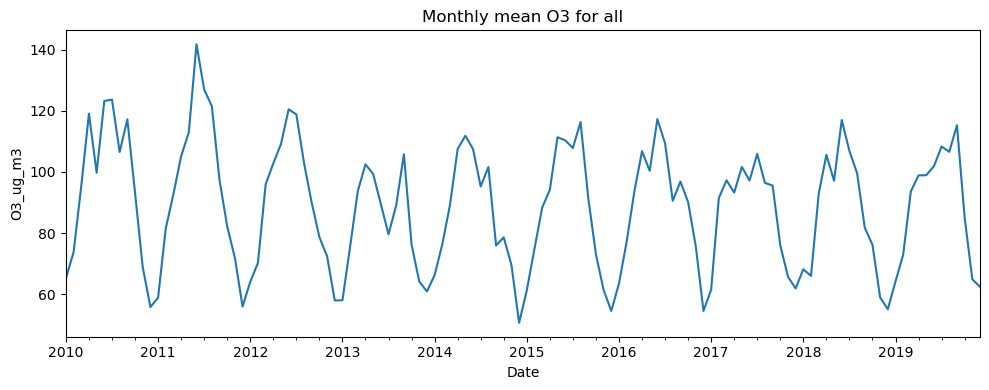

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
monthly.plot()
plt.title(f"Monthly mean O3 for {loc}")
plt.xlabel("Date")
plt.ylabel("O3_ug_m3")
plt.tight_layout()
plt.show()


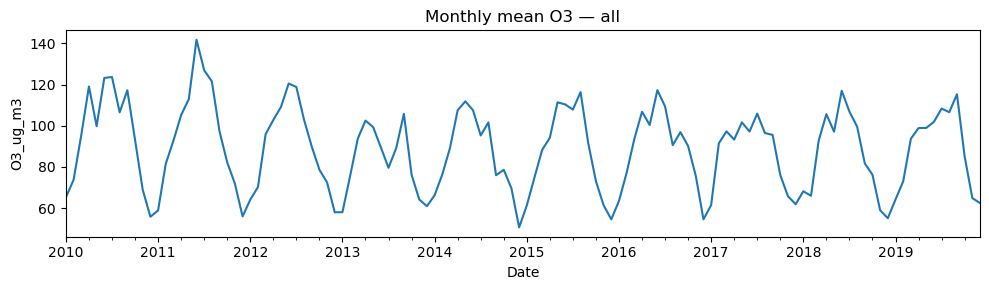

In [25]:
top3 = top_locations.index[:3]
for loc in top3:
    df_loc = df_features[df_features["location"] == loc].set_index("Date").sort_index()
    monthly = df_loc["O3_ug_m3"].resample("M").mean().dropna()
    plt.figure(figsize=(10,3))
    monthly.plot()
    plt.title(f"Monthly mean O3 — {loc}")
    plt.xlabel("Date"); plt.ylabel("O3_ug_m3")
    plt.tight_layout()
    plt.show()


In [26]:
df_features["year_month"] = df_features["Date"].dt.to_period("M")
pivot = df_features.pivot_table(
    index="year_month",
    columns="location",
    values="O3_ug_m3",
    aggfunc="mean"
)
pivot = pivot.sort_index()
pivot.head()


location,all
year_month,
2010-01,65.230370
2010-02,73.753571
2010-03,95.402581
2010-04,119.055333
2010-05,99.751613


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# ensure Date column is datetime
df_features["Date"] = pd.to_datetime(df_features["Date"], errors="coerce")

# sort for time series operations
df_features = df_features.sort_values("Date")


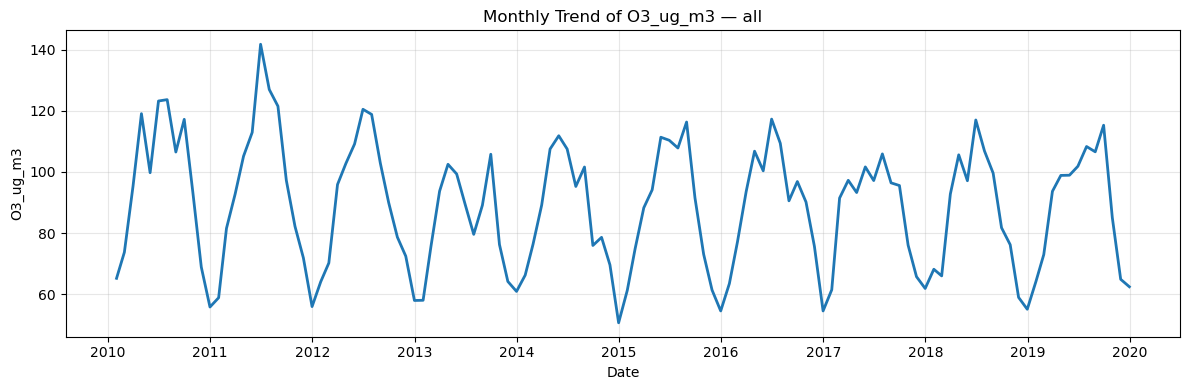

In [29]:
def plot_location_trend(df, location_col, value_col, location_name):
    # filter by location
    df_loc = df[df[location_col] == location_name].copy()
    df_loc = df_loc.set_index("Date").sort_index()

    # resample to monthly mean
    monthly = df_loc[value_col].resample("M").mean()

    plt.figure(figsize=(12, 4))
    plt.plot(monthly.index, monthly.values, linewidth=2)
    plt.title(f"Monthly Trend of {value_col} — {location_name}")
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# EXAMPLE:
plot_location_trend(df_features, "location", "O3_ug_m3", "all")


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

df_features["Date"] = pd.to_datetime(df_features["Date"], errors="coerce")
df_features = df_features.sort_values("Date")


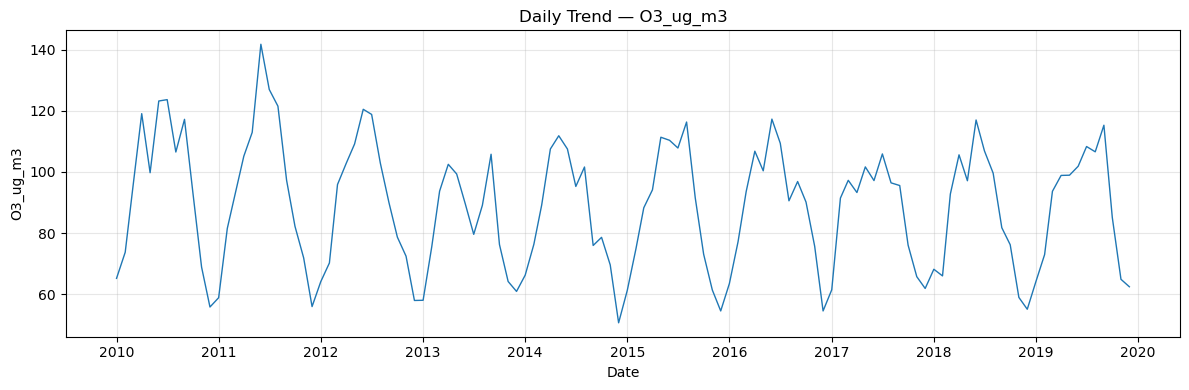

In [31]:
def plot_daily_trend(df, value_col):
    plt.figure(figsize=(12,4))
    plt.plot(df["Date"], df[value_col], linewidth=1)
    plt.title(f"Daily Trend — {value_col}")
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_daily_trend(df_features, "O3_ug_m3")


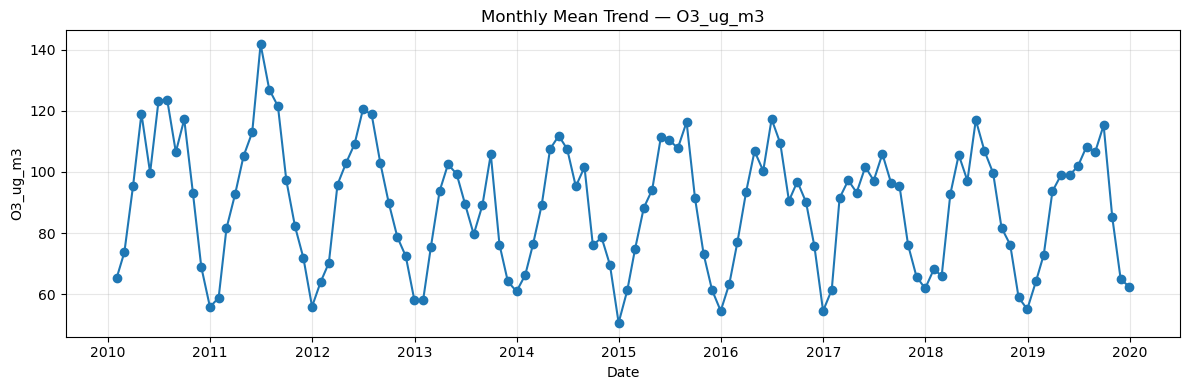

In [32]:
def plot_monthly_trend(df, value_col, how="mean"):
    df_m = df.set_index("Date")[value_col].resample("M").agg(how)

    plt.figure(figsize=(12,4))
    plt.plot(df_m.index, df_m.values, marker="o")
    plt.title(f"Monthly {how.title()} Trend — {value_col}")
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_monthly_trend(df_features, "O3_ug_m3", how="mean")


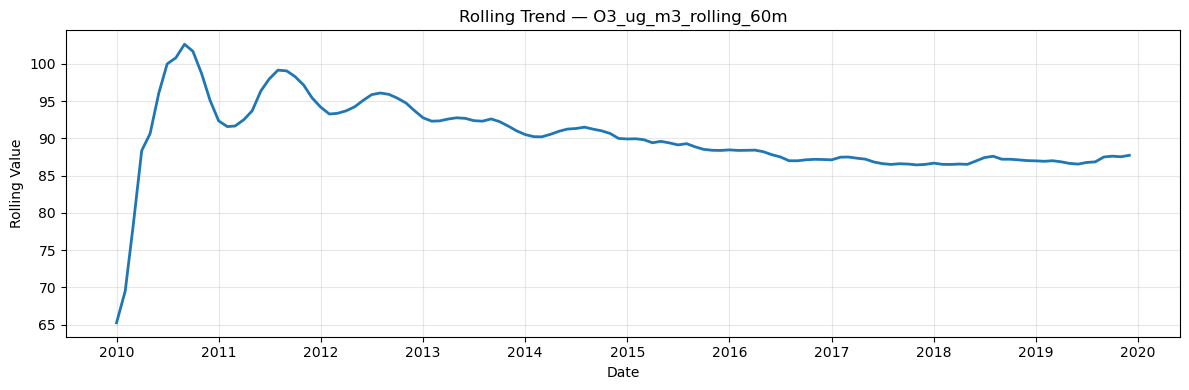

In [33]:
def plot_rolling(df, rolling_col):
    df_r = df.set_index("Date")[rolling_col].dropna()

    plt.figure(figsize=(12,4))
    plt.plot(df_r.index, df_r.values, linewidth=2)
    plt.title(f"Rolling Trend — {rolling_col}")
    plt.xlabel("Date")
    plt.ylabel("Rolling Value")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_rolling(df_features, "O3_ug_m3_rolling_60m")


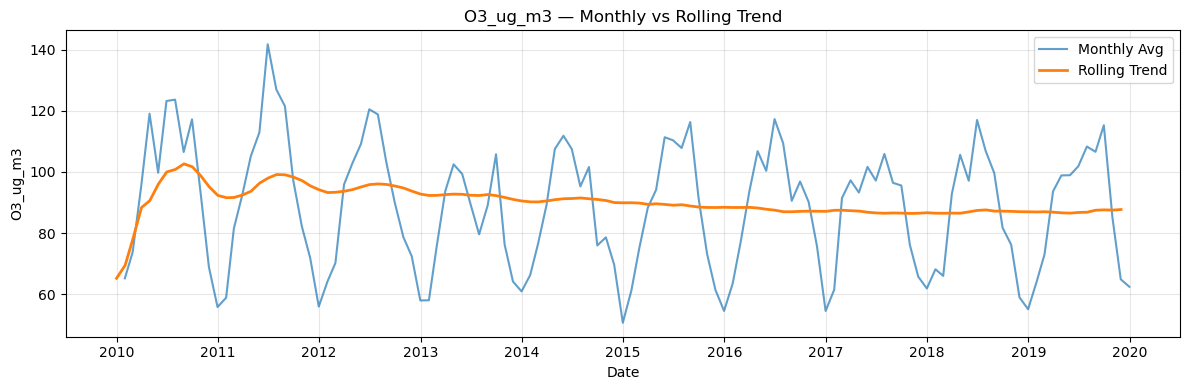

In [34]:
def plot_combined(df, value_col, rolling_col):
    df_loc = df.set_index("Date")

    monthly = df_loc[value_col].resample("M").mean()
    rolling = df_loc[rolling_col]

    plt.figure(figsize=(12,4))
    plt.plot(monthly.index, monthly.values, label="Monthly Avg", alpha=0.7)
    plt.plot(rolling.index, rolling.values, label="Rolling Trend", linewidth=2)
    plt.title(f"{value_col} — Monthly vs Rolling Trend")
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_combined(df_features, "O3_ug_m3", "O3_ug_m3_rolling_60m")


Saved: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\visualizations\trend_daily_raw.png


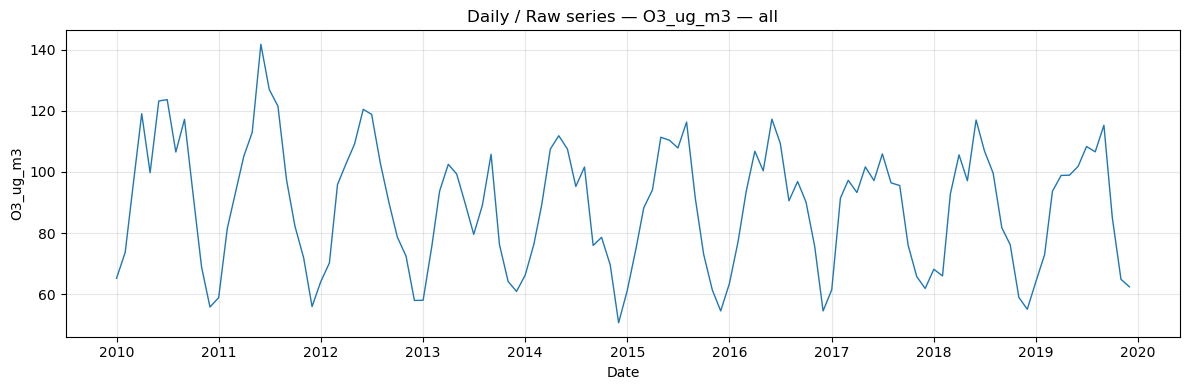

Saved: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\visualizations\trend_monthly.png


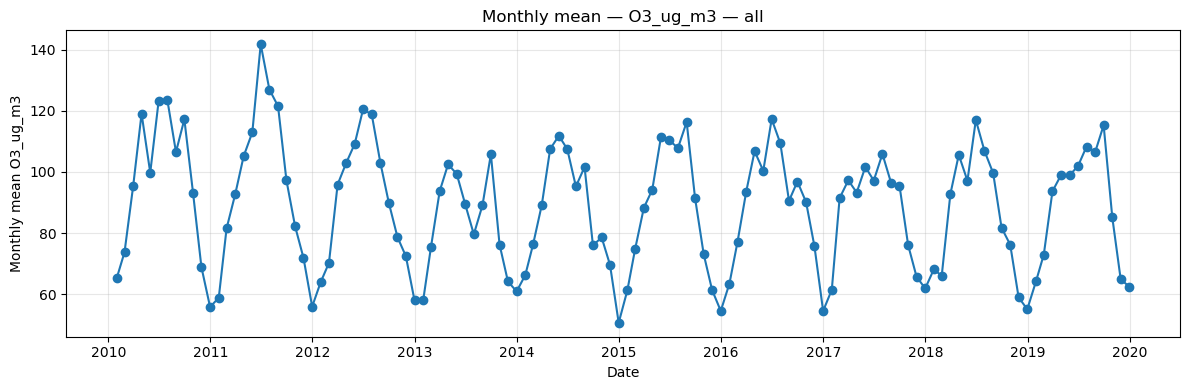

Saved: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\visualizations\trend_rolling_existing.png


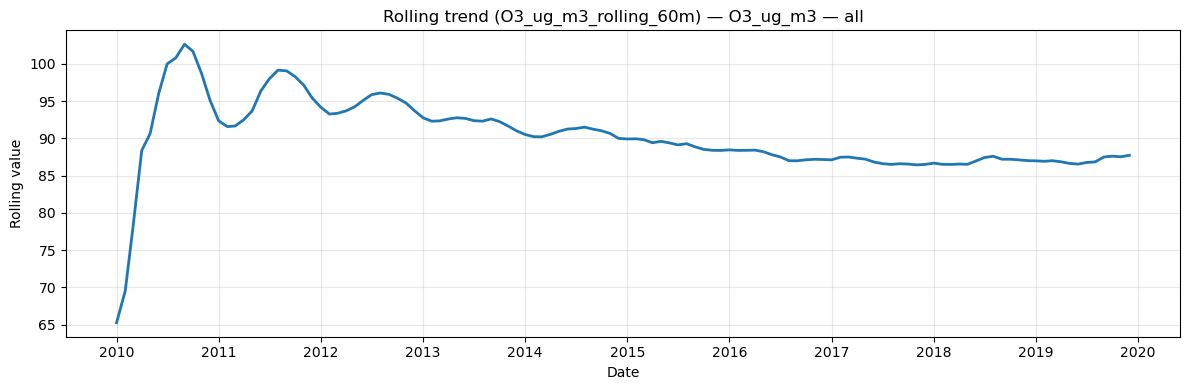

Saved: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\visualizations\stl_trend.png


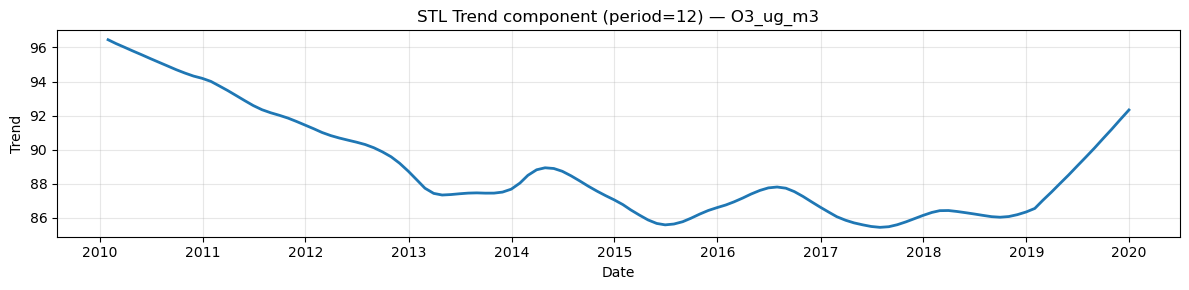

Saved: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\visualizations\stl_seasonal.png


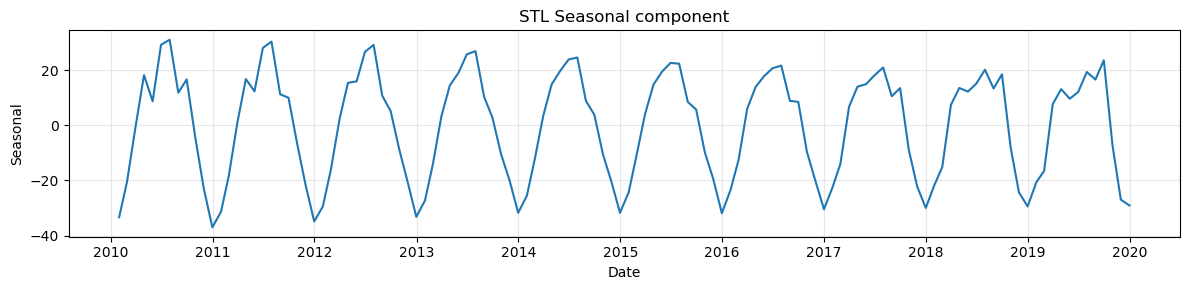

Saved: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\visualizations\stl_residual.png


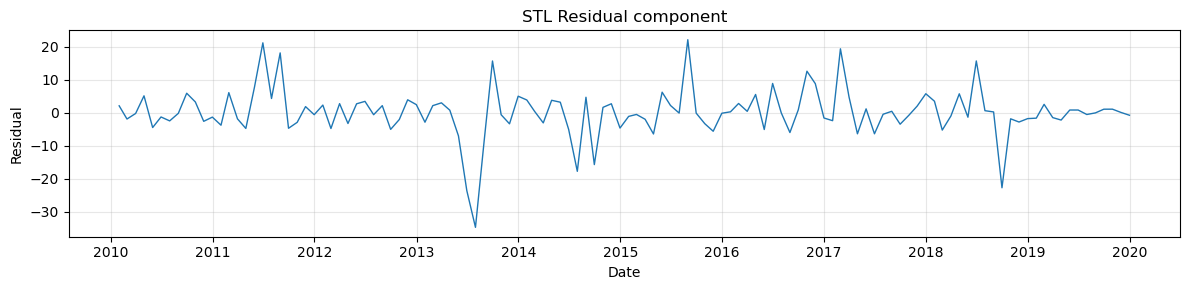

Saved: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\visualizations\seasonal_month_curve.png


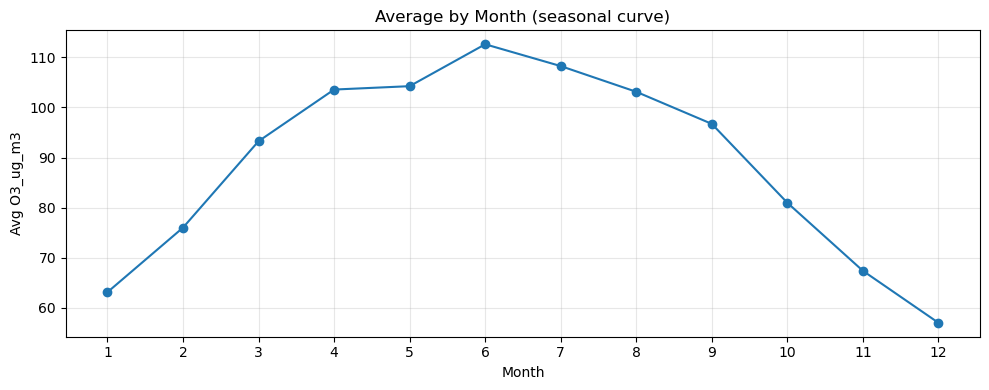

Saved: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\visualizations\year_over_year_monthly.png


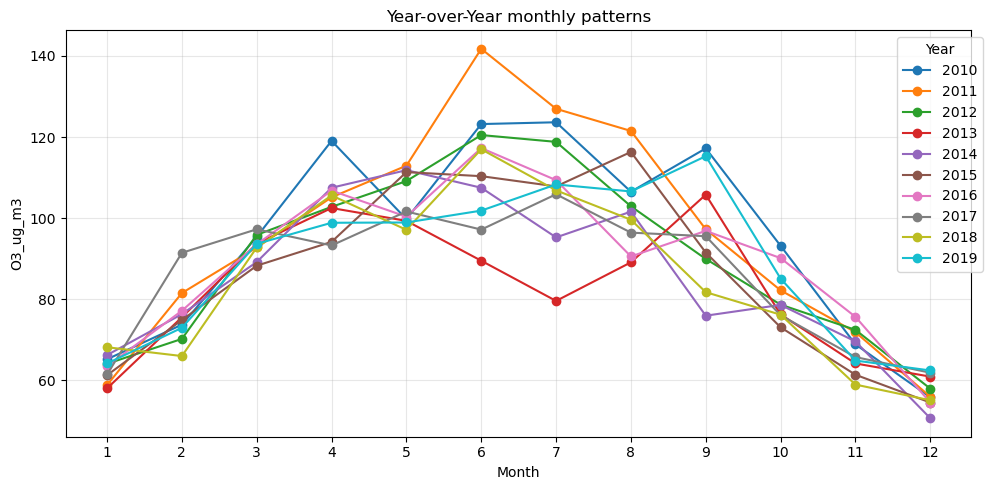


Trend dashboard generation complete.


In [ ]:
# Trend Dashboard

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# optional: for STL
try:
    from statsmodels.tsa.seasonal import STL
    have_stl = True
except Exception:
    have_stl = False

# -------- CONFIG --------
DF = df_features  # your dataframe
VALUE_COL = "O3_ug_m3"                 # main measurement column
ROLLING_COL = "O3_ug_m3_rolling_60m"   # existing rolling col (if any)
OUTPUT_DIR = Path("analysis_outputs/visualizations")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# If your dataset contains a location column, choose the single location.
if "location" in DF.columns:
    unique_locs = DF["location"].unique()
    if len(unique_locs) > 1:
        print("Warning: dataset has multiple locations; using the first:", unique_locs[0])
    chosen_loc = unique_locs[0]
    df_loc = DF[DF["location"] == chosen_loc].copy()
else:
    df_loc = DF.copy()
    chosen_loc = None

# Ensure Date column exists and is datetime
if "Date" not in df_loc.columns:
    raise KeyError("No 'Date' column found in df_features. Rename your timestamp column to 'Date' first.")

df_loc["Date"] = pd.to_datetime(df_loc["Date"], errors="coerce")
df_loc = df_loc.dropna(subset=["Date"]).sort_values("Date")
df_loc = df_loc.reset_index(drop=True)

# Set index for timeseries operations
ts = df_loc.set_index("Date").sort_index()

# Monthly series (monthly mean)
monthly = ts[VALUE_COL].resample("M").mean().dropna()

# Prepare rolling series:
# Prefer existing ROLLING_COL if present; otherwise compute short (3-month) and long (12-month) rolling
if ROLLING_COL in ts.columns and not ts[ROLLING_COL].isna().all():
    rolling_series = ts[ROLLING_COL].dropna()
    rolling_note = f"using existing column '{ROLLING_COL}'"
else:
    # compute two rolling windows on monthly series for visual comparison
    rolling_short = monthly.rolling(window=3, center=True).mean().dropna()   # 3-month smooth
    rolling_long = monthly.rolling(window=12, center=True).mean().dropna()   # 12-month smooth
    rolling_series = None
    rolling_note = "computed 3-month and 12-month rolling from monthly mean"

# Helper for saving figures
def save_fig(fig, name):
    path = OUTPUT_DIR / f"{name}.png"
    fig.savefig(path, bbox_inches="tight", dpi=200)
    print("Saved:", path.resolve())

# ---- 1) Daily / raw time series ----
fig = plt.figure(figsize=(12,4))
plt.plot(ts.index, ts[VALUE_COL], linewidth=1)
title = f"Daily / Raw series — {VALUE_COL}"
if chosen_loc:
    title += f" — {chosen_loc}"
plt.title(title)
plt.xlabel("Date"); plt.ylabel(VALUE_COL)
plt.grid(alpha=0.3)
plt.tight_layout()
save_fig(fig, "trend_daily_raw")
plt.show()
plt.close(fig)

# ---- 2) Monthly aggregation ----
fig = plt.figure(figsize=(12,4))
plt.plot(monthly.index, monthly.values, marker="o", linewidth=1.5)
title = f"Monthly mean — {VALUE_COL}"
if chosen_loc:
    title += f" — {chosen_loc}"
plt.title(title)
plt.xlabel("Date"); plt.ylabel(f"Monthly mean {VALUE_COL}")
plt.grid(alpha=0.3)
plt.tight_layout()
save_fig(fig, "trend_monthly")
plt.show()
plt.close(fig)

# ---- 3) Rolling trends ----
if rolling_series is not None:
    fig = plt.figure(figsize=(12,4))
    plt.plot(rolling_series.index, rolling_series.values, linewidth=2)
    title = f"Rolling trend ({ROLLING_COL}) — {VALUE_COL}"
    if chosen_loc:
        title += f" — {chosen_loc}"
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Rolling value")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    save_fig(fig, "trend_rolling_existing")
    plt.show()
    plt.close(fig)
else:
    # show short and long rolling on same figure (they are both monthly-indexed)
    fig = plt.figure(figsize=(12,4))
    if not rolling_short.empty:
        plt.plot(rolling_short.index, rolling_short.values, linewidth=1.8, label="3-month rolling")
    if not rolling_long.empty:
        plt.plot(rolling_long.index, rolling_long.values, linewidth=2.2, label="12-month rolling")
    title = f"Rolling trends (computed) — {VALUE_COL}"
    if chosen_loc:
        title += f" — {chosen_loc}"
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Rolling (computed)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    save_fig(fig, "trend_rolling_computed")
    plt.show()
    plt.close(fig)

# ---- 4) STL decomposition (trend / seasonal / residual) ----
if have_stl:
    # STL expects a regularly spaced series and a seasonal period; monthly -> period=12
    # Ensure monthly series has no gaps; reindex for monthly range
    monthly_full = monthly.asfreq("M")
    monthly_full = monthly_full.interpolate(method="time", limit=3)  # gentle interpolation for small gaps

    period = 12  # monthly seasonality
    try:
        stl = STL(monthly_full, period=period, robust=True)
        res = stl.fit()
        # trend
        fig = plt.figure(figsize=(12,3))
        plt.plot(res.trend.index, res.trend.values, linewidth=2)
        plt.title(f"STL Trend component (period={period}) — {VALUE_COL}")
        plt.xlabel("Date"); plt.ylabel("Trend")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        save_fig(fig, "stl_trend")
        plt.show()
        plt.close(fig)

        # seasonal
        fig = plt.figure(figsize=(12,3))
        plt.plot(res.seasonal.index, res.seasonal.values, linewidth=1.5)
        plt.title("STL Seasonal component")
        plt.xlabel("Date"); plt.ylabel("Seasonal")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        save_fig(fig, "stl_seasonal")
        plt.show()
        plt.close(fig)

        # residual
        fig = plt.figure(figsize=(12,3))
        plt.plot(res.resid.index, res.resid.values, linewidth=1)
        plt.title("STL Residual component")
        plt.xlabel("Date"); plt.ylabel("Residual")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        save_fig(fig, "stl_residual")
        plt.show()
        plt.close(fig)
    except Exception as e:
        print("STL decomposition failed:", str(e))
else:
    print("statsmodels not available — skipping STL decomposition. Install with: pip install statsmodels")

# ---- 5) Seasonal (month-of-year) curve ----
# Use monthly series grouped by month-of-year
if not monthly.empty:
    df_month = monthly.copy()
    df_month.index = pd.to_datetime(df_month.index)
    by_month = df_month.groupby(df_month.index.month).mean()
    # reorder months 1..12
    months = list(range(1,13))
    seasonal = by_month.reindex(months).squeeze()

    fig = plt.figure(figsize=(10,4))
    plt.plot(months, seasonal.values, marker="o")
    plt.xticks(months)
    plt.title("Average by Month (seasonal curve)")
    plt.xlabel("Month")
    plt.ylabel(f"Avg {VALUE_COL}")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    save_fig(fig, "seasonal_month_curve")
    plt.show()
    plt.close(fig)
else:
    print("Monthly series empty — cannot compute month-of-year seasonal curve.")

# ---- 6) Year-over-year comparison (monthly values across years) ----
# Create a pivot where rows are months (1..12) and columns are years
if not monthly.empty:
    monthly_df = monthly.to_frame(name=VALUE_COL)
    monthly_df["year"] = monthly_df.index.year
    monthly_df["month"] = monthly_df.index.month
    pivot = monthly_df.pivot_table(index="month", columns="year", values=VALUE_COL, aggfunc="mean")
    fig = plt.figure(figsize=(10,5))
    # Plot each year as a separate line
    for yr in pivot.columns:
        plt.plot(pivot.index, pivot[yr].values, marker="o", label=str(yr))
    plt.xticks(range(1,13))
    plt.title("Year-over-Year monthly patterns")
    plt.xlabel("Month")
    plt.ylabel(VALUE_COL)
    plt.legend(title="Year", bbox_to_anchor=(1.02, 1.0))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    save_fig(fig, "year_over_year_monthly")
    plt.show()
    plt.close(fig)
else:
    print("Monthly series empty — skipping year-over-year comparison.")

print("\nTrend dashboard generation complete.")


In [ ]:
from IPython.display import IFrame, display

# ---------- Helper: re-fit & forecast aligned to test period ----------
def forecast_aligned_to_test(name, train_series, full_series, test_index, horizon):
    """
    name: model name string ("Naive", "MovingAvg(6)", "ARIMA", "Prophet")
    train_series: monthly series used as the baseline training (all data before test start)
    full_series: entire monthly series (to provide access if needed)
    test_index: pd.DatetimeIndex of months to forecast (length = h)
    horizon: len(test_index)
    returns: pd.Series indexed by test_index with forecasted values
    """
    if name == "Naive":
        val = train_series.iloc[-1]
        return pd.Series([val] * horizon, index=test_index)
    if name == "MovingAvg(6)":
        ma = train_series.rolling(window=6).mean().dropna()
        last = ma.iloc[-1] if len(ma) > 0 else train_series.mean()
        return pd.Series([last] * horizon, index=test_index)
    if name == "ARIMA" and have_arima:
        try:
            m = pm.auto_arima(train_series, seasonal=True, m=12, suppress_warnings=True, error_action="ignore")
            pred = m.predict(n_periods=horizon)
            return pd.Series(pred, index=test_index)
        except Exception as e:
            print("ARIMA eval failed:", e)
            return pd.Series([np.nan]*horizon, index=test_index)
    if name == "Prophet" and have_prophet:
        try:
            dfp = train_series.reset_index().rename(columns={"Date": "ds", 0: "y"}) \
                        if isinstance(train_series, pd.Series) else \
                    train_series.reset_index().rename(columns={train_series.name: "y", "Date":"ds"})
            # ensure names are correct
            dfp = pd.DataFrame({"ds": train_series.index, "y": train_series.values})
            m = Prophet()
            m.fit(dfp)
            future = m.make_future_dataframe(periods=horizon, freq="M")
            fc = m.predict(future).set_index("ds")["yhat"].iloc[-horizon:]
            fc.index = test_index
            return pd.Series(fc.values, index=test_index)
        except Exception as e:
            print("Prophet eval failed:", e)
            return pd.Series([np.nan]*horizon, index=test_index)
    # fallback: Naive
    val = train_series.iloc[-1]
    return pd.Series([val] * horizon, index=test_index)


# determine proper training cutoff for evaluation: we want train up to month BEFORE test starts
if len(test) > 0:
    # test.index[0] is first test month. train_for_eval must include data up to test.index[0] - 1 month
    cutoff_date = test.index[0] - pd.offsets.MonthBegin(1)
    train_for_eval = monthly[ monthly.index <= cutoff_date ]
    if train_for_eval.empty:
        # fallback: use the earlier train we already had
        train_for_eval = train.copy()
else:
    train_for_eval = train.copy()

# aligned forecast horizon equals length of test
h_eval = len(test)
eval_index = test.index

# compute aligned forecasts for each model name that exists in models_forecasts
aligned_forecasts = {}
for model_name in list(models_forecasts.keys()):
    aligned_forecasts[model_name] = forecast_aligned_to_test(model_name, train_for_eval, monthly, eval_index, h_eval)

# compute metrics using aligned forecasts
metrics_list = []
for name, fc in aligned_forecasts.items():
    if h_eval > 0:
        actual = test.loc[eval_index].values
        pred = fc.loc[eval_index].values
        # if pred or actual contain NaN reduce gracefully
        mask = ~np.isnan(actual) & ~np.isnan(pred)
        if mask.sum() > 0:
            m_rmse = np.sqrt(mean_squared_error(actual[mask], pred[mask]))
            m_mape = mean_absolute_percentage_error(actual[mask], pred[mask])
        else:
            m_rmse = np.nan
            m_mape = np.nan
    else:
        m_rmse = np.nan
        m_mape = np.nan
    metrics_list.append({"model": name, "rmse": m_rmse, "mape": m_mape})

metrics_df = pd.DataFrame(metrics_list).set_index("model")
metrics_df.to_csv(OUTDIR / "forecast_metrics.csv")
print("Saved metrics to:", (OUTDIR / "forecast_metrics.csv").resolve())
print("\nMetrics:\n", metrics_df)

# also overwrite combined forecast CSV to include aligned forecasts (for the test window) and the future forecasts
aligned_df = pd.DataFrame(aligned_forecasts)
aligned_df.to_csv(OUTDIR / "forecast_table_aligned_to_test.csv")
print("Saved aligned forecast table to:", (OUTDIR / "forecast_table_aligned_to_test.csv").resolve())

# ---------- SAFE display of interactive dashboard ----------
# if plotly cannot render inline due to missing nbformat, display saved HTML via iframe
html_path = OUTDIR / "dashboard.html"
if html_path.exists():
    try:
        # attempt normal fig.show() first (works if environment supports it)
        fig.show()
    except Exception as e:
        print("Inline display failed; showing saved HTML dashboard instead. Reason:", e)
        try:
            display(IFrame(src=str(html_path.resolve()), width=1100, height=800))
            print("Displayed dashboard HTML via IFrame.")
        except Exception as e2:
            print("IFrame fallback also failed:", e2)
            print("Open the file manually:", html_path.resolve())
else:
    print("dashboard.html not found; if you need interactive HTML, it is saved earlier with fig.write_html()")


12:43:17 - cmdstanpy - INFO - Chain [1] start processing
12:43:18 - cmdstanpy - INFO - Chain [1] done processing


Saved metrics to: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\forecasts\forecast_metrics.csv

Metrics:
                    rmse      mape
model                            
Naive         38.784691  0.354869
MovingAvg(6)  20.507844  0.206624
Prophet        9.193278  0.065715
Saved aligned forecast table to: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\forecasts\forecast_table_aligned_to_test.csv
Inline display failed; showing saved HTML dashboard instead. Reason: Mime type rendering requires nbformat>=4.2.0 but it is not installed


Displayed dashboard HTML via IFrame.


In [45]:
FORECAST_YEARS = 10
FORECAST_MONTHS = FORECAST_YEARS * 12
print("Forecast horizon:", FORECAST_MONTHS, "months")

fc_table = pd.DataFrame(index=pd.date_range(
    start=monthly.index[-1] + pd.offsets.MonthBegin(),
    periods=FORECAST_MONTHS,
    freq="MS"
))

# -----------------------
# Naive model
# -----------------------
last_val = monthly.iloc[-1]
fc_table["Naive"] = last_val

# -----------------------
# Moving Average (6 months)
# -----------------------
fc_table["MovingAvg"] = monthly.iloc[-6:].mean()

# -----------------------
# Prophet model
# -----------------------
from prophet import Prophet
df_prophet = monthly.reset_index()
df_prophet.columns = ["ds", "y"]

m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=FORECAST_MONTHS, freq="MS")
forecast = m.predict(future)

prophet_fc = forecast.set_index("ds")[["yhat"]].iloc[-FORECAST_MONTHS:]
fc_table["Prophet"] = prophet_fc["yhat"]

# Save to CSV
OUTDIR = Path("analysis_outputs/forecasts")
OUTDIR.mkdir(exist_ok=True, parents=True)
fc_path = OUTDIR / "forecast_table_10yr.csv"
fc_table.to_csv(fc_path)

print("\nSaved 10-year forecast to:", fc_path)
display(fc_table.head(), fc_table.tail())


12:57:08 - cmdstanpy - INFO - Chain [1] start processing


Forecast horizon: 120 months


12:57:08 - cmdstanpy - INFO - Chain [1] done processing



Saved 10-year forecast to: analysis_outputs\forecasts\forecast_table_10yr.csv


,Naive,MovingAvg,Prophet
2020-01-01,62.474194,90.446065,55.345164
2020-02-01,62.474194,90.446065,58.139757
2020-03-01,62.474194,90.446065,71.366483
2020-04-01,62.474194,90.446065,95.286370
2020-05-01,62.474194,90.446065,107.647552


,Naive,MovingAvg,Prophet
2029-08-01,62.474194,90.446065,110.760788
2029-09-01,62.474194,90.446065,89.745843
2029-10-01,62.474194,90.446065,98.580932
2029-11-01,62.474194,90.446065,86.574439
2029-12-01,62.474194,90.446065,75.364971


In [ ]:
# ---------------------------
# Combined Monthly + Yearly Interactive Dashboard (10-year forecast)
# Requirements: pandas, numpy, plotly. Optional: prophet, pmdarima, kaleido
# ---------------------------
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import IFrame, display

# plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# optional models
try:
    from prophet import Prophet
    HAVE_PROPHET = True
except Exception:
    HAVE_PROPHET = False

try:
    import pmdarima as pm
    HAVE_ARIMA = True
except Exception:
    HAVE_ARIMA = False

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ---------------------------
# CONFIG
# ---------------------------
OUTDIR = Path("analysis_outputs/forecasts")
OUTDIR.mkdir(parents=True, exist_ok=True)

VALUE_COL = "O3_ug_m3"          # change if different
DATE_COL = "Date"
FORECAST_YEARS = 10
FORECAST_MONTHS = FORECAST_YEARS * 12
TEST_MONTHS = 12                 # holdout for backtest metrics (if enough history)

# ---------------------------
# LOAD / PREP DATA
# ---------------------------
if "df_features" not in globals():
    raise RuntimeError("df_features not found in the notebook session. Load it first.")

DF = df_features.copy()
if DATE_COL not in DF.columns:
    # try common alternatives
    for alt in ["date", "timestamp", "ds"]:
        if alt in DF.columns:
            DF = DF.rename(columns={alt: DATE_COL})
            break
if DATE_COL not in DF.columns:
    raise KeyError("No 'Date' column found. Ensure your timestamp column is named 'Date'.")

DF[DATE_COL] = pd.to_datetime(DF[DATE_COL], errors="coerce")
DF = DF.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)

# single location assumption: pick first if multiple
if "location" in DF.columns:
    locs = DF["location"].unique()
    if len(locs) > 1:
        print("Multiple locations found — dashboard will use the first:", locs[0])
    DF = DF[DF["location"] == DF["location"].unique()[0]]

monthly = DF.set_index(DATE_COL)[VALUE_COL].resample("M").mean().dropna()
if monthly.empty:
    raise RuntimeError("Monthly series empty after resampling. Check VALUE_COL and Date.")

# forecast future index (starts next month after last observed)
future_index = pd.date_range(start=monthly.index[-1] + pd.offsets.MonthBegin(1),
                             periods=FORECAST_MONTHS, freq="M")

# ---------------------------
# BUILD FORECASTS (fit on full history for forward-looking)
# ---------------------------
models_forecasts_future = dict()
ci_intervals = dict()  # store (low, high) series where available

# Naive (last observed)
last_val = monthly.iloc[-1]
models_forecasts_future["Naive"] = pd.Series([last_val]*FORECAST_MONTHS, index=future_index)

# Moving average (6-month)
ma_last = monthly.rolling(window=6).mean().dropna().iloc[-1] if len(monthly)>=6 else monthly.mean()
models_forecasts_future["MovingAvg(6)"] = pd.Series([ma_last]*FORECAST_MONTHS, index=future_index)

# ARIMA (auto_arima) - point forecasts + try CI
if HAVE_ARIMA:
    try:
        arima_model = pm.auto_arima(monthly, seasonal=True, m=12, suppress_warnings=True, error_action="ignore")
        arima_pred = arima_model.predict(n_periods=FORECAST_MONTHS)
        models_forecasts_future["ARIMA"] = pd.Series(arima_pred, index=future_index)
        try:
            _, conf = arima_model.predict(n_periods=FORECAST_MONTHS, return_conf_int=True)
            arima_low = pd.Series(conf[:,0], index=future_index)
            arima_high= pd.Series(conf[:,1], index=future_index)
            ci_intervals["ARIMA"] = (arima_low, arima_high)
        except Exception:
            ci_intervals["ARIMA"] = (None, None)
    except Exception as e:
        print("ARIMA fitting failed:", e)
        HAVE_ARIMA = False

# Prophet
if HAVE_PROPHET:
    try:
        dfp = monthly.reset_index().rename(columns={monthly.index.name or "Date": "ds", monthly.name or VALUE_COL: "y"})
        # ensure correct names
        dfp = pd.DataFrame({"ds": monthly.index, "y": monthly.values})
        m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        m.fit(dfp)
        fut = m.make_future_dataframe(periods=FORECAST_MONTHS, freq="M")
        fc = m.predict(fut).set_index("ds")
        prophet_fc = fc["yhat"].iloc[-FORECAST_MONTHS:]
        prophet_low = fc["yhat_lower"].iloc[-FORECAST_MONTHS:]
        prophet_high = fc["yhat_upper"].iloc[-FORECAST_MONTHS:]
        prophet_fc.index = future_index
        prophet_low.index = future_index
        prophet_high.index = future_index
        models_forecasts_future["Prophet"] = pd.Series(prophet_fc.values, index=future_index)
        ci_intervals["Prophet"] = (prophet_low, prophet_high)
    except Exception as e:
        print("Prophet failed:", e)
        HAVE_PROPHET = False

# Save combined future forecast table (point forecasts)
fc_future_df = pd.DataFrame(models_forecasts_future)
fc_future_df.index.name = DATE_COL
fc_future_df.to_csv(OUTDIR / "forecast_table_10yr.csv")
print("Saved future forecasts to:", (OUTDIR / "forecast_table_10yr.csv").resolve())

# ---------------------------
# BACKTEST: Build aligned forecasts for test period (holdout) to compute RMSE/MAPE
# We hold out last TEST_MONTHS months (if enough history), refit models on training portion and forecast the test window.
# ---------------------------
metrics = []
aligned_forecasts = {}
if len(monthly) > TEST_MONTHS + 6:  # ensure enough history
    test = monthly.iloc[-TEST_MONTHS:]
    train_full = monthly.iloc[:-TEST_MONTHS]
    eval_index = test.index
    # helper to produce aligned forecast for a model name
    def forecast_for_eval(name, train_series, horizon, eval_index):
        if name == "Naive":
            return pd.Series([train_series.iloc[-1]]*horizon, index=eval_index)
        if name == "MovingAvg(6)":
            ma = train_series.rolling(window=6).mean().dropna()
            val = ma.iloc[-1] if len(ma)>0 else train_series.mean()
            return pd.Series([val]*horizon, index=eval_index)
        if name == "ARIMA" and HAVE_ARIMA:
            try:
                m = pm.auto_arima(train_series, seasonal=True, m=12, suppress_warnings=True, error_action="ignore")
                pred = m.predict(n_periods=horizon)
                return pd.Series(pred, index=eval_index)
            except Exception:
                return pd.Series([np.nan]*horizon, index=eval_index)
        if name == "Prophet" and HAVE_PROPHET:
            try:
                dfp = pd.DataFrame({"ds": train_series.index, "y": train_series.values})
                m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
                m.fit(dfp)
                fut = m.make_future_dataframe(periods=horizon, freq="M")
                pfc = m.predict(fut).set_index("ds")["yhat"].iloc[-horizon:]
                pfc.index = eval_index
                return pd.Series(pfc.values, index=eval_index)
            except Exception:
                return pd.Series([np.nan]*horizon, index=eval_index)
        # fallback -> naive
        return pd.Series([train_series.iloc[-1]]*horizon, index=eval_index)

    # produce and evaluate
    for name in list(models_forecasts_future.keys()):
        aligned = forecast_for_eval(name, train_full, len(test), test.index)
        aligned_forecasts[name] = aligned
        # compute metrics where overlap exists
        mask = ~np.isnan(aligned.values) & ~np.isnan(test.values)
        if mask.sum() > 0:
            rmse_v = np.sqrt(mean_squared_error(test.values[mask], aligned.values[mask]))
            mape_v = mean_absolute_percentage_error(test.values[mask], aligned.values[mask])
        else:
            rmse_v = np.nan
            mape_v = np.nan
        metrics.append({"model": name, "rmse": rmse_v, "mape": mape_v})
else:
    # Not enough history to backtest properly
    for name in list(models_forecasts_future.keys()):
        metrics.append({"model": name, "rmse": np.nan, "mape": np.nan})
metrics_df = pd.DataFrame(metrics).set_index("model")
metrics_df.to_csv(OUTDIR / "forecast_metrics.csv")
print("Saved metrics to:", (OUTDIR / "forecast_metrics.csv").resolve())

# ---------------------------
# YEARLY AGGREGATES (historical + forecast years)
# ---------------------------
hist_yearly = monthly.resample("Y").mean()
hist_yearly.index = hist_yearly.index.year.astype(int)

fc_future_reset = fc_future_df.reset_index().rename(columns={fc_future_df.index.name or "index": "Date"})
# ensure Date column parsed
fc_future_reset["Date"] = pd.to_datetime(fc_future_reset[DATE_COL], errors="coerce")
fc_future_reset = fc_future_reset.dropna(subset=["Date"]).set_index("Date")
fc_yearly = fc_future_reset.groupby(fc_future_reset.index.year).mean()
fc_yearly.index = fc_yearly.index.astype(int)

start_year = int(min(hist_yearly.index.min(), fc_yearly.index.min()))
end_year = int(max(hist_yearly.index.max(), fc_yearly.index.max()))
years = list(range(start_year, end_year+1))
combined_yearly = pd.DataFrame(index=years); combined_yearly.index.name="year"
for y,v in hist_yearly.items():
    combined_yearly.loc[y,"Historical"]=v
for col in fc_yearly.columns:
    combined_yearly[col]=np.nan
    for y,v in fc_yearly[col].items():
        combined_yearly.loc[y,col]=v

combined_yearly.reset_index().to_csv(OUTDIR / "yearly_aggregates_10yr.csv", index=False)
print("Saved yearly aggregates to:", (OUTDIR / "yearly_aggregates_10yr.csv").resolve())

# ---------------------------
# BUILD COMBINED INTERACTIVE DASHBOARD (Plotly)
# layout: row1 = monthly actual + forecasts + CIs, row2 = yearly aggregates chart, row3 = metrics & table
# ---------------------------
fig = make_subplots(rows=3, cols=1, shared_xaxes=False,
                    row_heights=[0.55, 0.30, 0.15],
                    specs=[[{"type":"xy"}],
                           [{"type":"xy"}],
                           [{"type":"table"}]])

# Row 1: Monthly actual
fig.add_trace(go.Scatter(x=monthly.index, y=monthly.values, name="Actual", mode="lines+markers", line=dict(width=2)),
              row=1, col=1)

# Add forecasts (future) as dashed lines
palette = px.colors.qualitative.Plotly
for i,(name, series) in enumerate(models_forecasts_future.items()):
    fig.add_trace(go.Scatter(x=series.index, y=series.values, mode="lines+markers", name=name,
                             line=dict(dash="dash", width=2, color=palette[i%len(palette)])), row=1, col=1)

# Add CIs if available
for name, (low, high) in ci_intervals.items():
    if low is not None and high is not None:
        fig.add_trace(go.Scatter(x=list(high.index)+list(low.index[::-1]),
                                 y=list(high.values)+list(low.values[::-1]),
                                 fill='toself', fillcolor='rgba(150,150,150,0.15)', line=dict(color='rgba(150,150,150,0)'),
                                 hoverinfo='skip', showlegend=True, name=f"{name} 95% CI"),
                      row=1, col=1)

# Highlight future region
fig.add_vrect(x0=future_index[0], x1=future_index[-1], fillcolor="LightYellow", opacity=0.08, line_width=0, row=1, col=1)

fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text=VALUE_COL, row=1, col=1)

# Row 2: Yearly aggregates line chart
# Historical + each model
if combined_yearly["Historical"].notna().any():
    fig.add_trace(go.Scatter(x=combined_yearly.index, y=combined_yearly["Historical"].values,
                             mode="lines+markers", name="Historical (yearly)", line=dict(width=3)),
                  row=2, col=1)
model_cols = [c for c in combined_yearly.columns if c!="Historical"]
for i,col in enumerate(model_cols):
    fig.add_trace(go.Scatter(x=combined_yearly.index, y=combined_yearly[col].values,
                             mode="lines+markers", name=str(col),
                             line=dict(dash="dash", width=2, color=palette[i%len(palette)])),
                  row=2, col=1)
fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text=f"Yearly mean of {VALUE_COL}", row=2, col=1)

# Row 3: Metrics table
metrics_display = metrics_df.reset_index()
metrics_display["rmse"] = metrics_display["rmse"].map(lambda v: f"{v:.3f}" if pd.notna(v) else "NA")
metrics_display["mape"] = metrics_display["mape"].map(lambda v: f"{v:.3%}" if pd.notna(v) else "NA")
table = go.Table(header=dict(values=["Model","RMSE","MAPE"], fill_color="paleturquoise", align="left"),
                 cells=dict(values=[metrics_display["model"], metrics_display["rmse"], metrics_display["mape"]],
                            fill_color="lavender", align="left"))
fig.add_trace(table, row=3, col=1)

fig.update_layout(height=1100, width=1200, title_text="Combined Forecast Dashboard — 10yr",
                  legend=dict(orientation="v", yanchor="top", y=0.95, xanchor="right", x=1.02))
html_path = OUTDIR / "dashboard_combined_10yr.html"
fig.write_html(html_path, include_plotlyjs="cdn")
print("Saved combined dashboard to:", html_path.resolve())

# try to save static image too (kaleido)
try:
    fig.write_image(str(OUTDIR / "dashboard_combined_10yr.png"), scale=2)
    print("Saved PNG snapshot:", (OUTDIR / "dashboard_combined_10yr.png").resolve())
except Exception as e:
    print("PNG snapshot not saved (install kaleido):", e)

# display saved html via iframe (safe)
try:
    display(IFrame(src=str(html_path), width=1200, height=800))
except Exception:
    print("Open the interactive dashboard HTML at:", html_path.resolve())

# final summary
print("\nModels produced:", list(models_forecasts_future.keys()))
print("Files saved in:", OUTDIR.resolve())
print("\nNOTE: Long-range forecasts (10 years) have high uncertainty. Use for scenario planning only.")


13:01:43 - cmdstanpy - INFO - Chain [1] start processing
13:01:43 - cmdstanpy - INFO - Chain [1] done processing
13:01:44 - cmdstanpy - INFO - Chain [1] start processing


Saved future forecasts to: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\forecasts\forecast_table_10yr.csv


13:01:44 - cmdstanpy - INFO - Chain [1] done processing


Saved metrics to: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\forecasts\forecast_metrics.csv
Saved yearly aggregates to: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\forecasts\yearly_aggregates_10yr.csv
Saved combined dashboard to: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\forecasts\dashboard_combined_10yr.html
PNG snapshot not saved (install kaleido): 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido




Models produced: ['Naive', 'MovingAvg(6)', 'Prophet']
Files saved in: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\forecasts

NOTE: Long-range forecasts (10 years) have high uncertainty. Use for scenario planning only.


In [50]:
# Trends dashboard (interactive with Plotly)
# Paste and run this cell. Requires: pandas, numpy, plotly. Optional: statsmodels for STL.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import IFrame, display
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

OUTDIR = Path("analysis_outputs/forecasts")
OUTDIR.mkdir(parents=True, exist_ok=True)

# --- Load or build monthly series (monthly already available from earlier cells) ---
if 'monthly' in globals():
    series = monthly.copy()
else:
    if 'df_features' in globals():
        DF = df_features.copy()
        # common date column heuristics
        date_candidates = [c for c in DF.columns if c.lower() in ("date","ds","timestamp")]
        if date_candidates:
            date_col = date_candidates[0]
        else:
            date_col = "Date"
        DF[date_col] = pd.to_datetime(DF[date_col], errors="coerce")
        DF = DF.dropna(subset=[date_col]).sort_values(date_col)
        if "location" in DF.columns:
            DF = DF[DF["location"] == DF["location"].unique()[0]]
        series = DF.set_index(date_col)["O3_ug_m3"].resample("M").mean().dropna()
    else:
        raise RuntimeError("No `monthly` series or `df_features` found in the session. Run earlier cells.")

series = series.sort_index()
series.name = "O3_ug_m3"

# --- Derived series: rolling means ---
roll6 = series.rolling(window=6, min_periods=1).mean()
roll12 = series.rolling(window=12, min_periods=1).mean()

# --- Seasonality: month-of-year summary ---
df_month = series.reset_index()
df_month["month"] = df_month["Date"].dt.month
monthly_mean_by_month = df_month.groupby("month")["O3_ug_m3"].mean().reindex(range(1,13))
monthly_median_by_month = df_month.groupby("month")["O3_ug_m3"].median().reindex(range(1,13))

# --- Year-over-year heatmap (years x months) ---
df_pivot = df_month.copy()
df_pivot["year"] = df_pivot["Date"].dt.year
# pivot: rows=year, cols=month, values=mean of month
heat = df_pivot.pivot_table(index="year", columns="month", values="O3_ug_m3", aggfunc="mean").reindex(columns=range(1,13)).sort_index()

# --- Yearly summary stats ---
yearly = df_pivot.groupby("year")["O3_ug_m3"].agg(["mean","min","max","std"]).rename(columns={
    "mean":"mean","min":"min","max":"max","std":"std"}).round(2)

# --- Optional decomposition (STL) ---
have_stl = False
try:
    from statsmodels.tsa.seasonal import STL
    have_stl = True
    stl = STL(series, period=12, robust=True)
    res = stl.fit()
    trend = res.trend
    seasonal = res.seasonal
    resid = res.resid
except Exception:
    trend = pd.Series(index=series.index, data=np.nan)
    seasonal = pd.Series(index=series.index, data=np.nan)
    resid = pd.Series(index=series.index, data=np.nan)

# --- Build interactive Plotly figure: 4 rows ---
fig = make_subplots(rows=4, cols=1, shared_xaxes=False,
                    row_heights=[0.45, 0.18, 0.25, 0.12],
                    specs=[[{"type":"xy"}],
                           [{"type":"xy"}],
                           [{"type":"heatmap"}],
                           [{"type":"table"}]],
                    vertical_spacing=0.06)

# Row 1: monthly series + rolling means
fig.add_trace(go.Scatter(x=series.index, y=series.values, mode="lines+markers", name="Monthly (actual)",
                         line=dict(width=2, color="#3B78E7")), row=1, col=1)
fig.add_trace(go.Scatter(x=roll6.index, y=roll6.values, mode="lines", name="6-mo rolling mean",
                         line=dict(width=2, dash="dash", color="#F39C12")), row=1, col=1)
fig.add_trace(go.Scatter(x=roll12.index, y=roll12.values, mode="lines", name="12-mo rolling mean",
                         line=dict(width=2, dash="dot", color="#27AE60")), row=1, col=1)

# If STL available, add trend line
if have_stl:
    fig.add_trace(go.Scatter(x=trend.index, y=trend.values, mode="lines", name="STL trend",
                             line=dict(width=3, color="#8E44AD")), row=1, col=1)

fig.update_xaxes(row=1, col=1, title_text="Date")
fig.update_yaxes(row=1, col=1, title_text="O3_ug_m3")

# Row 2: monthly seasonality (bar) + median overlay
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
fig.add_trace(go.Bar(x=months, y=monthly_mean_by_month.values, name="Mean by month", marker_color="#3498DB", opacity=0.7),
              row=2, col=1)
fig.add_trace(go.Scatter(x=months, y=monthly_median_by_month.values, mode="lines+markers", name="Median by month",
                         line=dict(width=2, color="#E74C3C")), row=2, col=1)
fig.update_yaxes(row=2, col=1, title_text="Avg O3 (monthly)")

# Row 3: heatmap (year x month)
heat_z = heat.values
heat_x = list(heat.columns)
heat_y = list(heat.index.astype(str))
fig.add_trace(go.Heatmap(z=heat_z, x=[months[m-1] for m in heat_x], y=heat_y,
                         colorscale="Viridis", colorbar=dict(title="O3")), row=3, col=1)
fig.update_xaxes(row=3, col=1, title_text="Month")
fig.update_yaxes(row=3, col=1, title_text="Year")

# Row 4: yearly summary table (mean, min, max, std)
tbl = yearly.reset_index()
header_vals = list(tbl.columns)
cell_vals = [tbl[col].tolist() for col in tbl.columns]
fig.add_trace(go.Table(header=dict(values=header_vals, fill_color="paleturquoise"),
                       cells=dict(values=cell_vals, fill_color="lavender")), row=4, col=1)

fig.update_layout(title_text="Trends Dashboard — Monthly & Seasonal Analysis", height=1100, width=1200,
                  showlegend=True)

# Save interactive HTML
html_path = OUTDIR / "trends_dashboard.html"
fig.write_html(html_path, include_plotlyjs="cdn")
print("Saved trends dashboard HTML to:", html_path.resolve())

# Try save PNG for inclusion in reports
png_path = OUTDIR / "trends_dashboard.png"
try:
    fig.write_image(str(png_path), scale=2)
    print("Saved PNG snapshot to:", png_path.resolve())
except Exception as e:
    print("PNG not saved (kaleido may be missing):", e)
    print("Install with: pip install -U kaleido")

# Display in notebook via IFrame (fallback to print path)
try:
    display(IFrame(src=str(html_path), width=1200, height=900))
except Exception:
    print("Open the HTML file manually at:", html_path.resolve())

# Quick local previews
print("\nMonthly series preview:")
display(series.tail(6).to_frame().T)

print("\nYearly summary (preview):")
display(yearly.tail(6))


Saved trends dashboard HTML to: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\forecasts\trends_dashboard.html
PNG not saved (kaleido may be missing): 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Install with: pip install -U kaleido



Monthly series preview:


Date,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31
O3_ug_m3,108.311613,106.585806,115.274667,85.116774,64.913333,62.474194



Yearly summary (preview):


,mean,min,max,std
year,,,,
2014,85.87,50.70,111.83,19.27
2015,87.09,54.57,116.32,21.77
2016,89.66,54.57,117.27,18.81
2017,87.00,61.49,105.90,16.10
2018,85.44,55.12,116.99,20.55
2019,89.43,62.47,115.27,18.89


In [51]:
# Merge Trends dashboard into Combined 10yr dashboard -> single master HTML
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import IFrame, display

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

OUTDIR = Path("analysis_outputs/forecasts")
OUTDIR.mkdir(parents=True, exist_ok=True)

# ---------- REQUIREMENTS CHECK ----------
# Objects expected: monthly, fc_future_df, combined_yearly, metrics_df
if 'monthly' not in globals():
    raise RuntimeError("monthly series not found in session. Run earlier cells.")
if 'fc_future_df' not in globals():
    # try read file if not in session
    p = OUTDIR / "forecast_table_10yr.csv"
    if p.exists():
        fc_future_df = pd.read_csv(p, parse_dates=['Date'], index_col='Date')
    else:
        raise RuntimeError("fc_future_df not found in session and forecast_table_10yr.csv not found.")
if 'combined_yearly' not in globals():
    # try to build from files
    ypath = OUTDIR / "yearly_aggregates_10yr.csv"
    if ypath.exists():
        combined_yearly = pd.read_csv(ypath).set_index('year')
    else:
        raise RuntimeError("combined_yearly not found in session and yearly_aggregates_10yr.csv missing.")
if 'metrics_df' not in globals():
    # try load metrics
    mpath = OUTDIR / "forecast_metrics.csv"
    if mpath.exists():
        metrics_df = pd.read_csv(mpath, index_col=0)
    else:
        metrics_df = None

# Optional STL decomposition
have_stl = False
try:
    from statsmodels.tsa.seasonal import STL
    have_stl = True
    stl_res = STL(monthly, period=12, robust=True).fit()
    stl_trend = stl_res.trend
    stl_seasonal = stl_res.seasonal
    stl_resid = stl_res.resid
except Exception:
    stl_trend = None
    stl_seasonal = None
    stl_resid = None

# Optional CI data for models (if available in earlier ci_intervals)
ci_intervals = globals().get("ci_intervals", {})

# Basic series and future
monthly = monthly.sort_index()
fc_future_df.index = pd.to_datetime(fc_future_df.index)
future_index = fc_future_df.index

# Prepare seasonality & heatmap data
df_month = monthly.reset_index().rename(columns={monthly.index.name or 'index': 'Date', monthly.name or 'O3_ug_m3': 'O3_ug_m3'})
df_month['month'] = df_month['Date'].dt.month
monthly_mean_by_month = df_month.groupby('month')['O3_ug_m3'].mean().reindex(range(1,13))
monthly_median_by_month = df_month.groupby('month')['O3_ug_m3'].median().reindex(range(1,13))
df_pivot = df_month.copy()
df_pivot['year'] = df_pivot['Date'].dt.year
heat = df_pivot.pivot_table(index='year', columns='month', values='O3_ug_m3', aggfunc='mean').reindex(columns=range(1,13)).sort_index()

# Colors / palette
palette = px.colors.qualitative.Plotly

# ---------- BUILD MASTER FIGURE ----------
# Layout: Row1 = Monthly actual + forecasts (big)
#         Row2 = Trends (monthly + STL trend + 6/12 roll)
#         Row3 = Seasonality (bar + median)
#         Row4 = Heatmap (year x month)
#         Row5 = Yearly aggregates
#         Row6 = Metrics table
fig = make_subplots(rows=6, cols=1,
                    row_heights=[0.38, 0.18, 0.12, 0.20, 0.08, 0.04],
                    specs=[[{"type":"xy"}],
                           [{"type":"xy"}],
                           [{"type":"xy"}],
                           [{"type":"heatmap"}],
                           [{"type":"xy"}],
                           [{"type":"table"}]],
                    vertical_spacing=0.04,
                    shared_xaxes=False)

# --- Row 1: Monthly actual + forecasts + CI ---
fig.add_trace(go.Scatter(x=monthly.index, y=monthly.values, name="Actual", mode="lines+markers",
                         line=dict(width=2, color=palette[0])), row=1, col=1)

# Add forecast models (dashed)
for i, col in enumerate(fc_future_df.columns):
    fig.add_trace(go.Scatter(x=fc_future_df.index, y=fc_future_df[col].values, mode="lines+markers",
                             name=str(col), line=dict(dash="dash", width=2, color=palette[(i+1)%len(palette)])),
                  row=1, col=1)
    # if CI available, plot filled band
    if col in ci_intervals and ci_intervals[col][0] is not None:
        low, high = ci_intervals[col]
        # ensure indexes align
        low = pd.Series(low).values if not isinstance(low, pd.Series) else low.values
        high = pd.Series(high).values if not isinstance(high, pd.Series) else high.values
        fig.add_trace(go.Scatter(
            x=list(fc_future_df.index) + list(fc_future_df.index[::-1]),
            y=list(high) + list(low[::-1]),
            fill='toself', fillcolor='rgba(150,150,150,0.15)', line=dict(color='rgba(150,150,150,0)'),
            hoverinfo='skip', showlegend=True, name=f"{col} CI"
        ), row=1, col=1)

# highlight future region
fig.add_vrect(x0=future_index[0], x1=future_index[-1], fillcolor="LightYellow", opacity=0.08, line_width=0, row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="O3_ug_m3", row=1, col=1)

# --- Row 2: Trends (monthly + rolling + STL trend) ---
roll6 = monthly.rolling(6, min_periods=1).mean()
roll12 = monthly.rolling(12, min_periods=1).mean()
fig.add_trace(go.Scatter(x=monthly.index, y=monthly.values, name="Monthly (trend view)", mode="lines", line=dict(width=1, color="#3B78E7")), row=2, col=1)
fig.add_trace(go.Scatter(x=roll6.index, y=roll6.values, name="6-mo roll", mode="lines", line=dict(width=2, dash="dash", color="#F39C12")), row=2, col=1)
fig.add_trace(go.Scatter(x=roll12.index, y=roll12.values, name="12-mo roll", mode="lines", line=dict(width=2, dash="dot", color="#27AE60")), row=2, col=1)
if have_stl and stl_trend is not None:
    fig.add_trace(go.Scatter(x=stl_trend.index, y=stl_trend.values, name="STL trend", mode="lines", line=dict(width=3, color="#8E44AD")), row=2, col=1)
fig.update_xaxes(row=2, col=1)
fig.update_yaxes(title_text="O3_ug_m3", row=2, col=1)

# --- Row 3: Seasonality (mean bar + median overlay) ---
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
fig.add_trace(go.Bar(x=months, y=monthly_mean_by_month.values, name="Mean by month", marker_color="#3498DB", opacity=0.7), row=3, col=1)
fig.add_trace(go.Scatter(x=months, y=monthly_median_by_month.values, mode="lines+markers", name="Median", line=dict(color="#E74C3C")), row=3, col=1)
fig.update_yaxes(title_text="Avg O3 (monthly)", row=3, col=1)

# --- Row 4: Heatmap (year x month) ---
heat_z = heat.values
heat_x = [months[m-1] for m in heat.columns]
heat_y = [str(y) for y in heat.index]
fig.add_trace(go.Heatmap(z=heat_z, x=heat_x, y=heat_y, colorscale="Viridis", colorbar=dict(title="O3")), row=4, col=1)
fig.update_xaxes(row=4, col=1, title_text="Month")
fig.update_yaxes(row=4, col=1, title_text="Year")

# --- Row 5: Yearly aggregates plot (reuse combined_yearly) ---
# Ensure index numeric
try:
    years_x = combined_yearly.index.astype(int).to_numpy()
except Exception:
    years_x = np.array([int(getattr(y, "year", int(y))) for y in combined_yearly.index])
if "Historical" in combined_yearly.columns:
    fig.add_trace(go.Scatter(x=years_x, y=combined_yearly["Historical"].values, mode="lines+markers", name="Historical (yearly)", line=dict(width=3, color="#17BECF")), row=5, col=1)
model_cols = [c for c in combined_yearly.columns if c!="Historical"]
for i,col in enumerate(model_cols):
    fig.add_trace(go.Scatter(x=years_x, y=combined_yearly[col].values, mode="lines+markers", name=str(col), line=dict(dash="dash", width=2, color=palette[(i+2)%len(palette)])), row=5, col=1)
fig.update_xaxes(title_text="Year", row=5, col=1)
fig.update_yaxes(title_text="Yearly mean of O3_ug_m3", row=5, col=1)

# --- Row 6: Metrics table ---
if metrics_df is not None:
    md = metrics_df.reset_index().copy()
    md.columns = ["model","rmse","mape"] if md.shape[1]==3 else md.columns
    md['rmse'] = md['rmse'].map(lambda v: f"{v:.3f}" if pd.notna(v) else "NA")
    md['mape'] = md['mape'].map(lambda v: (f"{v:.3%}" if pd.notna(v) else "NA"))
    header = list(md.columns)
    cells = [md[col].tolist() for col in md.columns]
else:
    header = ["Model","RMSE","MAPE"]
    cells = [[],[],[]]
fig.add_trace(go.Table(header=dict(values=header, fill_color="paleturquoise"),
                       cells=dict(values=cells, fill_color="lavender")), row=6, col=1)

# ---------- Layout adjustments ----------
fig.update_layout(title_text="MASTER Dashboard — Combined Forecast + Trends (10yr)", height=1600, width=1300,
                  legend=dict(orientation="v", yanchor="top", y=0.95, xanchor="right", x=1.02))

# Save HTML + PNG
html_master = OUTDIR / "dashboard_master_10yr.html"
fig.write_html(html_master, include_plotlyjs="cdn")
print("Saved master dashboard HTML to:", html_master.resolve())

try:
    png_master = OUTDIR / "dashboard_master_10yr.png"
    fig.write_image(str(png_master), scale=2)
    print("Saved master PNG snapshot to:", png_master.resolve())
except Exception as e:
    print("PNG snapshot not saved (kaleido missing?):", e)

# Show via IFrame
try:
    display(IFrame(src=str(html_master), width=1200, height=900))
except Exception:
    print("Open the file manually at:", html_master.resolve())

# Summary prints
print("\nMaster dashboard generated. Files in:", OUTDIR.resolve())


Saved master dashboard HTML to: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\forecasts\dashboard_master_10yr.html
PNG snapshot not saved (kaleido missing?): 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido




Master dashboard generated. Files in: C:\Users\HP\Desktop\Capstone Project\analysis\analysis_outputs\forecasts
